# Prepare data

I saved 'perchase_credit_history.csv' after EDA and feature engineering as a new .csv file called 'creditcard_after.csv', which I will use for Assignment 5.

In [44]:
import pandas as pd
import numpy as np

df = pd.read_csv('creditcard_after.csv')

In [45]:
# check for data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442458 entries, 0 to 442457
Data columns (total 30 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   Year_Month                               442458 non-null  object 
 1   Agency_Number                            442458 non-null  int64  
 2   Agency_Name                              442458 non-null  object 
 3   Cardholder_Last_Name                     442458 non-null  object 
 4   Cardholder_First_Initial                 442458 non-null  object 
 5   Description                              442458 non-null  object 
 6   Amount                                   442458 non-null  float64
 7   Vendor                                   442458 non-null  object 
 8   Transaction_Date                         442458 non-null  object 
 9   Posted_Date                              442458 non-null  object 
 10  Merchant_Category               

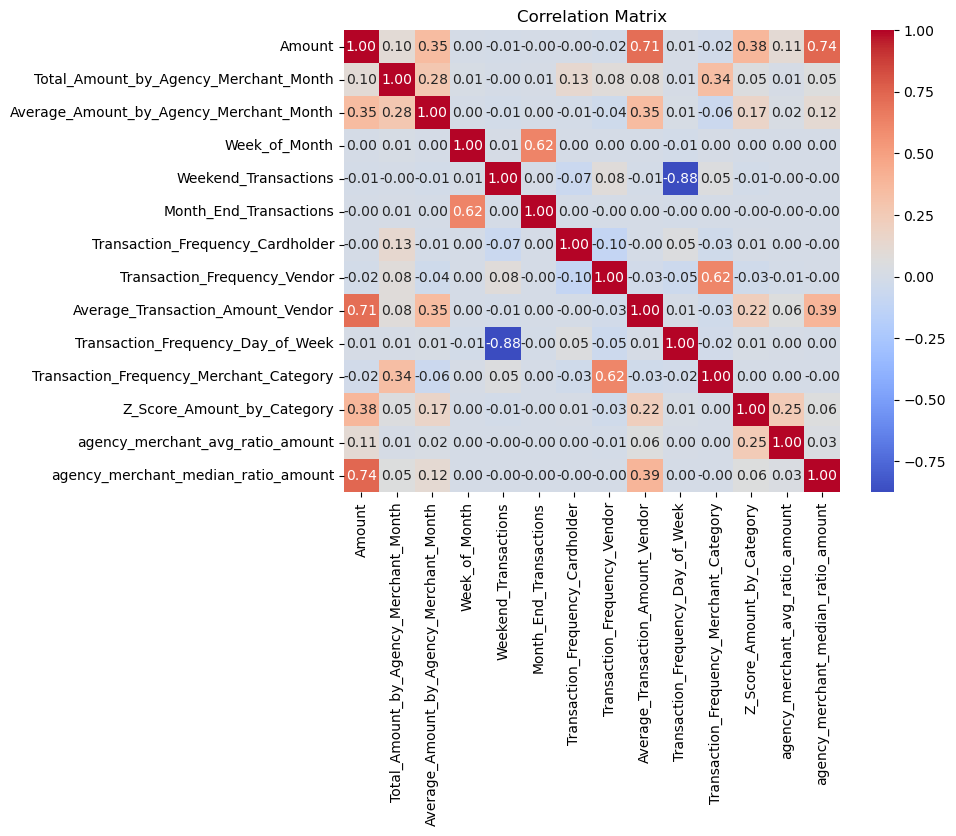

In [57]:
# Calculate the correlation matrix
correlation_matrix = X.corr()

# Create a heatmap to visualize the correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f") # 'annot=True' adds the correlation values to the heatmap
plt.title("Correlation Matrix")
plt.show()

In [47]:
# Check for NaN or infinity values
if df.isnull().values.any() or not np.isfinite(df).all().all():
    # Fill missing values with median
    df.fillna(df.median(), inplace=True)

# Keep 2 decimal points
df = df.round(2)

/var/folders/h5/5b7_hbjj0090vtlzc7lw_b3r0000gn/T/ipykernel_22176/2070304602.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.median(), inplace=True)


In [48]:
# Select the features I want to use in the HBOS and ECOD model
selected_features = [
    'Amount',
    'Total_Amount_by_Agency_Merchant_Month',
    'Average_Amount_by_Agency_Merchant_Month',
    'Week_of_Month',
    'Weekend_Transactions',
    'Month_End_Transactions',
    'Transaction_Frequency_Cardholder',
    'Transaction_Frequency_Vendor',
    'Average_Transaction_Amount_Vendor',
    'Transaction_Frequency_Day_of_Week',
    'Transaction_Frequency_Merchant_Category',
    'Z_Score_Amount_by_Category',
    'agency_merchant_avg_ratio_amount',
    'agency_merchant_median_ratio_amount'
]

# Histogram-based Outlier Score (HBOS)

The first method I'm using is the HBOS (Histogram-based Outlier Score) model for anomaly detection. This method constructs histograms for each feature and calculates an anomaly score based on the deviation from the expected distribution. Anomaly scores are used to classify data points as normal or outliers.

In [49]:
# Create a new DataFrame with the selected features
X = df[selected_features]

from sklearn.model_selection import train_test_split

#split data
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [50]:
from pyod.models.hbos import HBOS

# Initialize and fit HBOS model with the training data
hbos = HBOS()
hbos.fit(X_train)

HBOS(alpha=0.1, contamination=0.1, n_bins=10, tol=0.5)

In [51]:
from pyod.models.hbos import HBOS
n_bins = 50
hbos = HBOS(n_bins=n_bins,contamination=0.05)
hbos.fit(X_train)

# Training data
y_train_scores = hbos.decision_function(X_train)
y_train_pred = hbos.predict(X_train)

# Test data
y_test_scores = hbos.decision_function(X_test)
y_test_pred = hbos.predict(X_test) # outlier labels (0 or 1)

# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , hbos.threshold_)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))

The threshold for the defined comtanimation rate: 27.947446874170506
The training data: {0: 336272, 1: 17694}
The training data: {0: 84019, 1: 4473}


Under 5% contamination rate, the threshold is calculated, which is around 27.947. Data points with anomaly scores above this threshold are classified as outliers.

# Determine the threshold

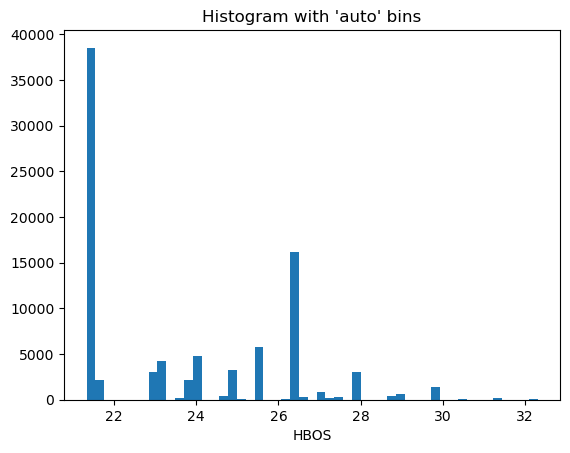

In [52]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto') 
plt.title("Histogram with 'auto' bins")
plt.xlabel('HBOS')
plt.show()

This histogram is created to visualize the distribution of anomaly scores. This can help in determining an appropriate threshold, I think the calculated thereshold is a resonable range to determine outliers.

# Descriptive statistics

Descriptive statistics for both the training and test data, categorized into normal and outlier groups. This includes summary statistics for all the selected features.

In [53]:
threshold = hbos.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,Amount,Total_Amount_by_Agency_Merchant_Month,Average_Amount_by_Agency_Merchant_Month,Week_of_Month,Weekend_Transactions,Month_End_Transactions,Transaction_Frequency_Cardholder,Transaction_Frequency_Vendor,Average_Transaction_Amount_Vendor,Transaction_Frequency_Day_of_Week,Transaction_Frequency_Merchant_Category,Z_Score_Amount_by_Category,agency_merchant_avg_ratio_amount,agency_merchant_median_ratio_amount,Anomaly_Score
0,Normal,336263,94.998672,378.08,41764.92,419.60,2.63,0.06,0.16,905.27,1803.56,414.57,78867.66,9451.76,-0.03,0.93,2.45,23.40
1,Outlier,17703,5.001328,1352.78,50031.54,568.55,3.31,0.54,0.16,1011.68,2704.55,700.69,49900.11,11022.93,0.58,2.21,63.99,29.02


#### Interpretation and Business Insights

- **Group "Normal"**: This group includes 94.99% of the training set. These are the data points that are considered normal by the model.

- **Group "Outlier"**: This group includes the outliers identified by the model (5.00% of the training set). These are data points considered as anomalies.

The analysis suggests that outliers exhibit distinct characteristics compared to normal transactions. These outliers tend to have significantly higher transaction amounts, more weekend transactions, and a higher transaction frequency, especially with vendors and merchant categories. Additionally, outliers are associated with larger week-of-month values. These insights can be valuable for fraud detection and understanding high-value transactions within the dataset, helping businesses focus on monitoring and investigating potentially fraudulent or unusual activities.

It's essential to further investigate these anomalies to determine if they are indeed fraudulent or just unusual but legitimate transactions, as some high-value transactions can be legitimate but may require additional scrutiny.

In [54]:
descriptive_stat_threshold(X_test,y_test_scores, threshold)

,Group,Count,Count %,Amount,Total_Amount_by_Agency_Merchant_Month,Average_Amount_by_Agency_Merchant_Month,Week_of_Month,Weekend_Transactions,Month_End_Transactions,Transaction_Frequency_Cardholder,Transaction_Frequency_Vendor,Average_Transaction_Amount_Vendor,Transaction_Frequency_Day_of_Week,Transaction_Frequency_Merchant_Category,Z_Score_Amount_by_Category,agency_merchant_avg_ratio_amount,agency_merchant_median_ratio_amount,Anomaly_Score
0,Normal,84018,94.944176,380.70,41414.23,411.09,2.63,0.06,0.16,907.27,1803.44,397.64,78902.59,9440.98,-0.03,0.94,2.44,23.4
1,Outlier,4474,5.055824,1111.59,49689.04,523.49,3.31,0.53,0.17,1038.61,2776.83,630.87,50633.06,11125.02,0.64,2.36,6.80,29.0


#### Interpretation:

- Outlier transactions have significantly higher average transaction amounts compared to Normal transactions, suggesting that they may be high-value or anomalous transactions.
- Outlier transactions have higher transaction frequencies, especially in terms of Cardholder and Vendor transactions.
- The Z-scores for Outlier transactions in terms of transaction amount by Merchant Category are notably higher.
- The "agency_merchant_avg_ratio_amount" and "agency_merchant_median_ratio_amount" features highlight the differences between Normal and Outlier transactions in terms of their spending behavior.

# Achieve Model Stability by Aggregating Multiple HBOS Models

HBOS models are sensitive to bin width, by aggregating multiple models with different bins, we can achieve better stability and accuracy.

In [20]:
#I need to split data again because the previous model has comprimised the x_train and x_test.
X = df[selected_features]
X_train, X_test= train_test_split(X, test_size=0.2, random_state=42)

In [21]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.hbos import HBOS

# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)

# Test a range of binning 
k_list = [5, 10, 15, 20, 25, 30, 50, 60, 75, 100]
n_clf = len(k_list)
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

# Modeling
for i in range(n_clf):
    k = k_list[i]
    hbos = HBOS(n_bins=k)
    hbos.fit(X_train_norm)
    # Store the results in each column:
    train_scores[:, i] = hbos.decision_function(X_train_norm) 
    test_scores[:, i] = hbos.decision_function(X_test_norm) 
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

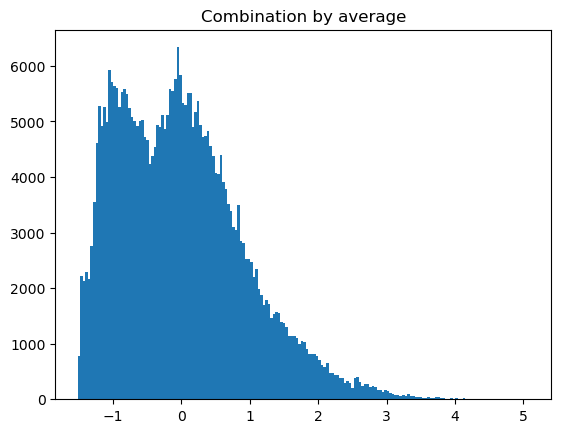

In [22]:
# Combination by average
# The test_scores_norm is 500 x 10. The "average" function will take the average of the 10 columns. The result "y_by_average" is a single column: 
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

#### the histogram suggest the threshold to be around 3.5, therefore I will generate descriptive statistic table using the suggested threshold. 

In [24]:
descriptive_stat_threshold(X_train,y_train_by_average, 3.5)

,Group,Count,Count %,Amount,Total_Amount_by_Agency_Merchant_Month,Average_Amount_by_Agency_Merchant_Month,Week_of_Month,Weekend_Transactions,Month_End_Transactions,Transaction_Frequency_Cardholder,Transaction_Frequency_Vendor,Average_Transaction_Amount_Vendor,Transaction_Frequency_Day_of_Week,Transaction_Frequency_Merchant_Category,Z_Score_Amount_by_Category,agency_merchant_avg_ratio_amount,agency_merchant_median_ratio_amount,Anomaly_Score
0,Normal,353518,99.873434,425.42,41991.38,426.14,2.66,0.08,0.16,910.30,1844.73,428.70,77487.50,9520.65,-0.00,1.00,5.53,-0.00
1,Outlier,448,0.126566,1539.51,189722.08,1139.71,4.50,0.99,0.91,1146.36,4919.97,574.16,23283.09,17175.55,0.21,1.45,4.64,3.84


#### Interpretation:

Using aggregated models with various values of n_bins (binning parameter), the detection of outliers depends on the specific k value. For example, with k=3.5, the model identifies 448 outliers in the test data, representing around 0.13% of the data. These outliers also have higher average transaction amounts, higher total amounts by agency and merchant category, and higher z-scores for the transaction amount by category. They share similar patterns with the the previous HBOS model.

#### Comparison and Conclusion for different HBOS methods:

- Both models (single HBOS and Agregated 10 HBOS) identify outliers with high transaction amounts, and their interpretations and insights are quite similar.
- The key difference lies in the percentage of data flagged as outliers. The HBOS model identifies a larger percentage (5.06%) compared to the aggregated models (0.13% for k=3.5). 
- The choice of the better model depends on specific use case. The aggregated model with a higher k value is a more conservative approach with fewer false positives, I think it's better in this case cuase the selected features high transaction by vendor or merchant is normal since they are cumulative amounts. 

# Empirical Cumulative Distribution-based Outlier Detection (ECOD)

ECOD model is a non-parametric approach that computes anomaly scores based on the data‘s distribution. It works by comparing each data point to all the others and measuring how different it is from the rest, data points with low cumulative probabilities as outliers. 

In [26]:
#I need to split data again because the previous model has comprimised the x_train and x_test.
X = df[selected_features]
X_train, X_test= train_test_split(X, test_size=0.2, random_state=42)

Hyperparameter Tuning: The key hyperparameter for ECOD was the contamination rate, which I will set to 5%. This value was chosen to ensure that only 5% of the data was classified as outliers.

In [27]:
from pyod.models.ecod import ECOD
ecod = ECOD(contamination=0.05)
ecod.fit(X_train)

# Training data
y_train_scores = ecod.decision_function(X_train)
y_train_pred = ecod.predict(X_train)

# Test data
y_test_scores = ecod.decision_function(X_test)
y_test_pred = ecod.predict(X_test) # outlier labels (0 or 1)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , ecod.threshold_)

The training data: {0: 336267, 1: 17699}
The training data: {0: 84014, 1: 4478}
The threshold for the defined comtanimation rate: 28.693305009697415


#### The threshold for the defined 5% contamination rate is at 28.6933. Data points with anomaly scores greater than this threshold were classified as outliers.

In [28]:
np.where(y_train_scores>28.693305009697415)

(array([     4,      6,     11, ..., 353931, 353961, 353962]),)

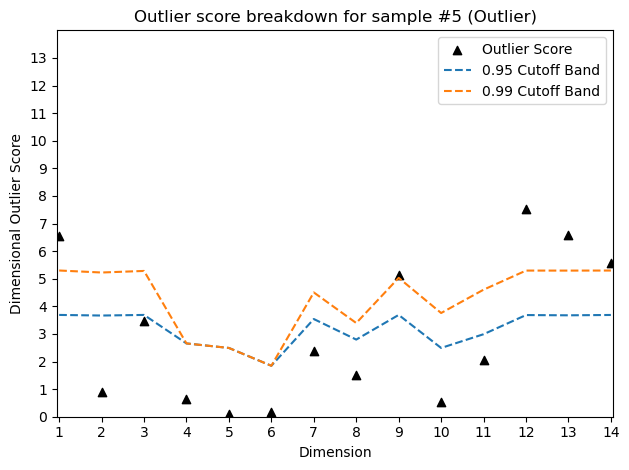

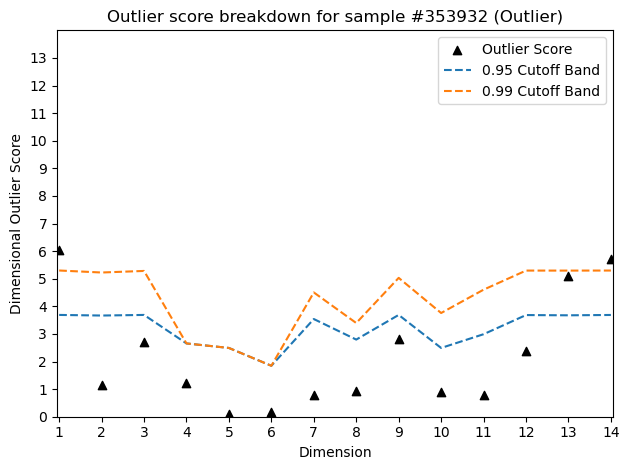

In [29]:
ecod.explain_outlier(4)
ecod.explain_outlier(353931)

#### Interpretation:
- Data point 4 and 353932 are considered two of outliers by the ECOD model.
- The outlier score is a measure of how unusual or anomalous a data point is in the context of the dataset. For data point 4, the outlier score indicates its high level of abnormality.
- The 0.95 cutoff band represents a threshold that separates the top 5% most abnormal data points from the rest of the dataset. Data points falling above this band are considered outliers, representing the most extreme anomalies.Data point 4 and 353932 both have some extreme outliers.
- The 0.99 cutoff band represents a more stringent threshold, separating the top 1% most abnormal data points. Data points above this band are considered even more extreme outliers.

# Determine a reasonable threshold

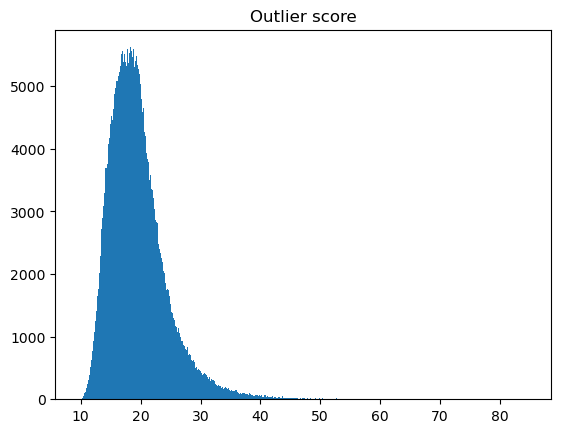

In [30]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto')
plt.title("Outlier score")
plt.show()

# Present the descriptive statistics of the normal and the abnormal groups


In [31]:
threshold = ecod.threshold_ 

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,Amount,Total_Amount_by_Agency_Merchant_Month,Average_Amount_by_Agency_Merchant_Month,Week_of_Month,Weekend_Transactions,Month_End_Transactions,Transaction_Frequency_Cardholder,Transaction_Frequency_Vendor,Average_Transaction_Amount_Vendor,Transaction_Frequency_Day_of_Week,Transaction_Frequency_Merchant_Category,Z_Score_Amount_by_Category,agency_merchant_avg_ratio_amount,agency_merchant_median_ratio_amount,Anomaly_Score
0,Normal,336267,94.999802,275.12,41172.31,367.05,2.65,0.08,0.15,900.95,1875.18,345.97,77733.19,9609.39,-0.07,0.85,1.97,18.83
1,Outlier,17699,5.000198,3309.23,61292.58,1566.85,2.88,0.18,0.26,1093.80,1344.07,2004.03,71447.65,8028.27,1.26,3.76,73.04,33.58


- 5% of the data was identified as outliers.
- The anomaly score for outliers is higher than normal group, which is 33.58 > 18.53. The threshold used for classification was approximately 28.69.

# Outliers Identified by HBOS and ECOD Models and Comparison

In [33]:
#I need to split data again because the previous model has comprimised the x_train and x_test.
X = df[selected_features]
X_train, X_test= train_test_split(X, test_size=0.2, random_state=42)

In [34]:
########
# HBOS #
########
from pyod.models.hbos import HBOS
n_bins = 50
hbos = HBOS(n_bins=n_bins, contamination=0.05)
hbos.fit(X_train)
y_train_hbos_pred = hbos.labels_
y_test_hbos_pred = hbos.predict(X_test)
y_train_hbos_scores = hbos.decision_function(X_train)
y_test_hbos_scores = hbos.decision_function(X_test)

########
# ECOD #
########
from pyod.models.ecod import ECOD
clf_name = 'ECOD'
ecod = ECOD(contamination=0.05)
ecod.fit(X_train)
y_train_ecod_pred = ecod.labels_
y_test_ecod_pred = ecod.predict(X_test)
y_train_ecod_scores = ecod.decision_scores_  # raw outlier scores
y_test_ecod_scores = ecod.decision_function(X_test)

# Thresholds
[ecod.threshold_, hbos.threshold_]

[28.693305009697415, 27.947446874170506]

In [35]:
pred_combine=pd.DataFrame({'HBOS_pred': y_test_hbos_pred, 'ECOD_pred': y_test_ecod_pred})
pd.crosstab(pred_combine['HBOS_pred'],pred_combine['ECOD_pred'])

ECOD_pred,0,1
HBOS_pred,,
0,80288,3731
1,3726,747


#### Summary:

- True Negatives (TN): Data points classified as normal (0) by both HBOS and ECOD. In this case, the data points are correctly identified as normal by both models. 80288 data points classified as 0 by both models

- False Positives (FP): Data points classified as outliers (1) by HBOS but as normal (0) by ECOD. These are cases where HBOS predicts an outlier while ECOD predicts it as normal. 3826 data points classified as FP.

- False Negatives (FN): Data points classified as normal (0) by HBOS but as outliers (1) by ECOD. These are cases where HBOS predicts normal data while ECOD detects an outlier. 3731 data points classified as FN.

- True Positives (TP): Data points classified as outliers (1) by both HBOS and ECOD. These are instances where both models correctly identify data points as outliers. 747 data points classified as TP.